In [1]:
# https://www.geeksforgeeks.org/python-how-to-make-a-terminal-progress-bar-using-tqdm/#:~:text=Usage,would%20not%20work%20at%20all.
# https://www.geeksforgeeks.org/saving-a-video-using-opencv/

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm import tqdm


def create_video_capture(input_dir: str = "VideoEntrada/", video_name_input: str = "input.mp4", frames: float = 30.0,
                         save_dir: str = "Resultados/VideoIterativo/", file_to_save: str = "ImagemMono.mp4") -> dict[
    int, np.ndarray]:
    # Create an object to read
    # from camera
    video = cv2.VideoCapture(0)

    i = 0
    video_frames = {}

    # We need to check if camera
    # is opened previously or not
    if (video.isOpened() == False):
        print("Error reading video file")

    # We need to set resolutions.
    # so, convert them from float to integer.
    frame_width = int(video.get(3))
    frame_height = int(video.get(4))

    size = (frame_width, frame_height)

    # Below VideoWriter object will create
    # a frame of above defined The output
    # is stored in 'filename.avi' file.
    video_reader_input = cv2.VideoWriter("{}/{}".format(input_dir, video_name_input),
                                         cv2.VideoWriter_fourcc(*'MP4V'),
                                         frames, size)

    video_reader_gray = cv2.VideoWriter("{}/{}".format(save_dir, file_to_save),
                                         cv2.VideoWriter_fourcc(*'MP4V'),
                                         frames, size, 0)

    while (True):
        ret, frame = video.read()

        if ret == True:

            # Write the frame into the
            # file 'filename.avi'
            video_reader_input.write(frame)
            video_frames[i] = frame
            i += 1

            # Display the frame
            # saved in the file
            cv2.imshow('Frame', frame)

            # Press S on keyboard
            # to stop the process
            if cv2.waitKey(1) & 0xFF == ord("q"):
                convert_to_gray_imgs(video_frames)
                apply_gaussian_blur(video_frames)
                for frame_vec in video_frames.values():
                    video_reader_gray.write(frame_vec)
                break

        # Break the loop
        else:
            break

    # When everything done, release
    # the video capture and video
    # write objects
    video.release()
    video_reader_input.release()
    video_reader_gray.release()

    # Closes all the frames
    cv2.destroyAllWindows()

    print("The video was successfully saved")
    return video_frames


def convert_to_gray_imgs(dict_imgs: dict[int, np.ndarray]) -> None:
    for key, img in dict_imgs.items():
        dict_imgs[key] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html
# https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1
def apply_gaussian_blur(dict_imgs: dict[int, np.ndarray], k_size: tuple[int, int] = (3, 3), sigma_x: int = 0,
                        sigma_y: int = 0) -> None:
    for key, img in tqdm(dict_imgs.items()):
        dict_imgs[key] = cv2.GaussianBlur(img, k_size, sigma_x, sigma_y)

In [2]:
dict_val = create_video_capture()
# convert_to_gray_imgs(dict_val)
# apply_gaussian_blur(dict_val)

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
100%|██████████| 50/50 [00:00<00:00, 5344.56it/s]

The video was successfully saved


img shape : (480, 640)


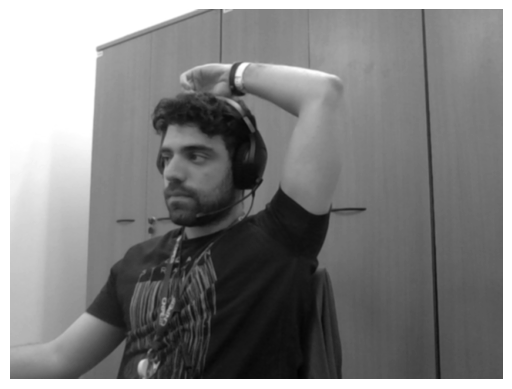

img shape : (480, 640)


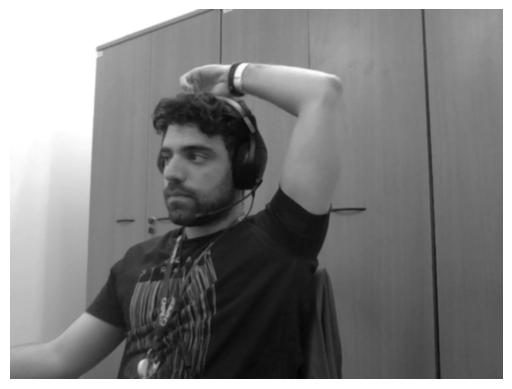

In [3]:
# https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/
# https://theailearner.com/2018/10/15/creating-video-from-images-using-opencv-python/
for i in range(0, 2):
    print("img shape : {}".format(dict_val[i].shape))
    plt.imshow(dict_val[i], cmap="gray", vmin=dict_val[i].min(), vmax=dict_val[i].max())
    plt.axis("off")
    plt.show()

In [4]:
from IPython.display import Video

Video(
    "VideoEntrada/input.mp4",
    embed=True)